# In generation Watermarks (Semantic Watermarks)

This exercise walks you through in generation watermarks. We start with the easier concept of Treering watermarks and switch to more involved concept of Gaussian Shading. These exercises take some time but give you a good understanding of how these techniques actually work.

The main idea of sematic watermarks is that we modify the latent from which images are generated. We embed a secret message in there and use the fact that we can also invert a diffusion process to recover something similar to our initial latent. We use this as a kind of communication channel through which we want to transmit a secret message. If we recognise the message again, we found the watermark. If not, the image was not watermarked, which makes it either real or generated by a different model or provider.

### Setup

please use GPU to run this notebook. If on Colab, be aware of the memory usage and delete tensors on GPU that are not necessary. Unfortunately, GPU RAM is scarce and loading to Stable diffusion models into cache takes up a lot of space already.

In [2]:
import torch

In [31]:
if torch.cuda.is_available():
    # Shows the nVidia GPUs, if this system has any
    !nvidia-smi

Tue Jun 24 13:29:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             31W /   70W |   10154MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#all dependencies are there by default
#!pip install diffusers
#!pip install transformers scipy accelerate
#!pip install huggingface-hub transformers diffusers

# Image generation with a simple model

For this exercise, we are using Stable Diffusion 2.1, since it is kind of a default for watermarking at the moment, because generation is cheap and fast and results look okayish. We can also deploy these techniques to better models like Flux.

First, we set some global parameters, do some imports and download the model

In [4]:
from torchvision import transforms
from PIL import Image
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionPipeline, AutoencoderKL

In [5]:
MODEL_ID = 'stabilityai/stable-diffusion-2-1-base'
guidance_scale = 7.5
num_inference_steps = 25
image_length = 512

In [7]:
#some helper functions

def img_to_latents(x: torch.Tensor, vae: AutoencoderKL):
    """
    Get latents from image given some autoencoder
    """
    x = 2. * x - 1.
    posterior = vae.encode(x).latent_dist
    latents = posterior.mean * 0.18215
    return latents

def pil_2_tensor(pil: Image):
    """
    Convert single PIL image to tensor
    """
    return transforms.ToTensor()(pil).unsqueeze(0)


def tensor_2_pil(tensor: torch.Tensor):
    """
    Convert single tensor to PIL image
    """
    return transforms.ToPILImage()(tensor.squeeze(0))


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# original pipe (used for generating images and also inversion)
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    scheduler=DDIMScheduler.from_pretrained(MODEL_ID, subfolder='scheduler'),
    torch_dtype=torch.float32,
    variant='fp16',
    safety_checker=None, requires_safety_checker=False,
    ).to(device)


Now, we are ready to actually run the image generation.

  0%|          | 0/25 [00:00<?, ?it/s]

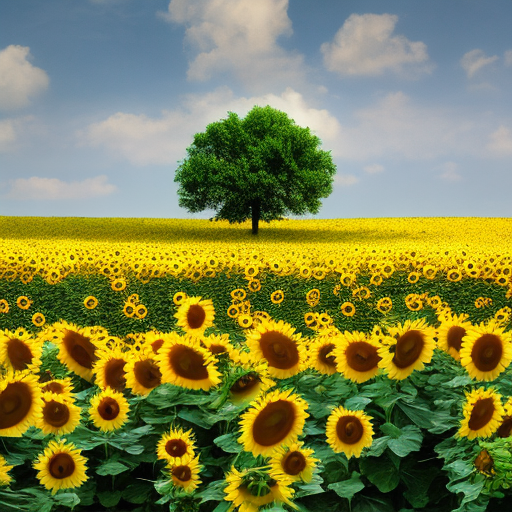

In [9]:
latent = torch.randn(size=(1,4,64,64))

prompt = "a tree on a sunflower field"
out = pipe(prompt, num_images_per_prompt=1, guidance_scale=guidance_scale,
           height=image_length, width=image_length,
           num_inference_steps=num_inference_steps,
           latents=latent,  # expects torch of size (batch_dim, num_latents_channels, width, height)
    )
img = out.images[0]  # is a PIL Image
display(img)


Diffusion is invertible. However, it is just an approximation as we can see if we compare the recovered latent and the real latent we started with.

In [11]:

inv_pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID,
                                                   scheduler=DDIMInverseScheduler.from_pretrained(MODEL_ID, subfolder='scheduler'),
                                                   torch_dtype=torch.float32,
                                                   variant='fp16',
                                                   safety_checker=None, requires_safety_checker=False
                                                   ).to(device)
vae = inv_pipe.vae
z0 = img_to_latents(pil_2_tensor(img).to(device), vae)
inv_zT, _ = inv_pipe(prompt="", negative_prompt="", guidance_scale=1.,
                     width=image_length, height=image_length,
                     num_inference_steps=num_inference_steps,
                     latents=z0,
                     output_type='latent', return_dict=False,)  # is a torch tensor

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
import numpy as np
diff_tensor = torch.round(latent.squeeze(0).cpu())-torch.round(inv_zT.cpu())
diff_tensor = diff_tensor.numpy()
print("number of matching signs ",np.count_nonzero(diff_tensor==0),"; expected number of matching signs for unrelated latents: ",len(diff_tensor.flatten())/2)


number of matching signs  10690 ; expected number of matching signs for unrelated latents:  8192.0


In [14]:
#free RAM on GPU
del z0, inv_zT, out
torch.cuda.empty_cache()

For convenience, we are going to wrap the image generation and inversion into two different methods

In [16]:
def generate_image(pipe,latent,prompt):
  '''
  Generate the image

  @param pipe: the stable diffusion pipe
  @param latent: a latent of dimensions 4x64x64
  @param prompt: a prompt you like to see in the image
  '''
    out = pipe(prompt, num_images_per_prompt=1, guidance_scale=guidance_scale,
           height=image_length, width=image_length,
           num_inference_steps=num_inference_steps,
           latents=latent.unsqueeze(0),  # expects torch of size (batch_dim, num_latents_channels, width, height)
    )
    img = out.images[0]  # is a PIL Image
    return img

def invert_image(inv_pipe,img):
  '''
  invert the image back to something close to the initial latent

  @param inv_pipe: inversion pipe
  @param img: the pillow image to invert
  '''
    z0 = img_to_latents(pil_2_tensor(img).to(device), vae)
    inv_zT, _ = inv_pipe(prompt="", negative_prompt="", guidance_scale=1.,
                     width=image_length, height=image_length,
                     num_inference_steps=num_inference_steps,
                     latents=z0,
                     output_type='latent', return_dict=False,)  # is a torch tensor
    return inv_zT.squeeze(0)


# Tree Ring Watermarks
## ...in the real space
Now it's your turn to write some code. The first idea is to embed a structure of concentric rings into the lantent and see what happens. And because rings are cumbersome, we use squares instead. First, you need to draw a random latent. Next, your task is to draw a sequence of concentric squares which are based on a bit string called secret or often ''watermarking key''. Embed these in the center of one or all of the latent channels

The exercise provides you with a structured class to fill out. How you do the code, is up to you.

In [11]:
class TreeRingWatermarkREAL:
    def __init__(self,bitlength):
        # draw self.secret as a bit string of length bitlength
        self.lantent_height = 64
        self.latent_channel = 4
        super()

    def random_latent(self):
        #generate a random tensor to use as an initial seed
        pass

    def generate(self):
        # embed concetric squares as either 1 or 0 into a random latent. return the latent
        pass

    def verify(self):
        # verify if your concentric squares are still there. be aware that there might be some noise on the image.
        # return True/False and maybe a confidence
        pass



In [ ]:
#idea of how your message should work. Try it a couple of times and have a look at the images
bitlength = 10
trwreal = TreeRingWatermarkREAL(bitlength)
latent = trwreal.generate()
img = generate_image(pipe,latent)
display(img)
inverted = invert_image(inv_pipe,img)
trwreal.verify(inverted)

now, this was not so hard. But also probably looks a bit off. Why could that be the case?

## ... in the fourier space
lets do this in fourier space now. This method embeds concetric circles into the fourier space of the latent, but drops the imaginary part. It therefore still alters the distribution, but less and should look better. Since the implementation is very complicated, the function is given. Just seed both accordingly to compare the results on the same prompt.

In [27]:
import copy
from scipy.stats import ncx2
class TreeRingWatermarkCOMPLEX:
'''
Code adapted from https://github.com/YuxinWenRick/tree-ring-watermark/tree/main.
This class provides code to generate a tree ring in the fourier space. It embeds a ring pattern in the fourier space of one latent channel only (channel 3 by default).
It computes a p-value if there is significant difference from a random sample with a chi squared test.
'''
    def __init__(self,bitlength):
        self.key = np.random.randint(0,2,size=bitlength)
        self.lantent_height = 64
        self.latent_channel = 4#
        self.latent_shape=(1,self.latent_channel,self.lantent_height,self.lantent_height)
        self.w_radius = bitlength
        self.w_channel = 3

        self.gt_patch = self._get_pattern(shape=self.latent_shape)
        #find watermarking mask
        self.watermarking_mask = torch.zeros(self.latent_shape, dtype=torch.bool)
        np_mask = self.__circle_mask(self.latent_shape[-1], r=self.w_radius)
        torch_mask = torch.tensor(np_mask)
        self.watermarking_mask[:, self.w_channel] = torch_mask

    def _get_pattern(self,shape):
        gt_init = torch.randn(shape)
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))
        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(self.w_radius, 0, -1):
            tmp_mask = self.__circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask)

            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()

        return gt_patch

    def generate(self):
        latents_clean = torch.randn(size = self.latent_shape)
        latents_w = latents_clean.float()
        latents_w_fft = torch.fft.fftshift(torch.fft.fft2(latents_w), dim=(-1, -2))
        latents_w_fft[self.watermarking_mask] = self.gt_patch[self.watermarking_mask].clone()
        latents_w = torch.fft.ifft2(torch.fft.ifftshift(latents_w_fft, dim=(-1, -2)))
        latents_w = latents_w.real
        return latents_w.to(device)

    def verify(self,latent):
        lat = latent.cpu()
        latent_fft = torch.fft.fftshift(torch.fft.fft2(lat), dim=(-1, -2))

        watermarking_mask = self.watermarking_mask[0]
        gt_patch = self.gt_patch[0]

        latent_fft = latent_fft[watermarking_mask].flatten()
        target_patch = gt_patch[watermarking_mask].flatten()
        target_patch = torch.concatenate([target_patch.real, target_patch.imag])
        latent_fft = torch.concatenate([latent_fft.real, latent_fft.imag])

        # p test
        simga = latent_fft.std()
        lambd = (target_patch ** 2 / simga ** 2).sum().item()
        x = (((latent_fft - target_patch) / simga) ** 2).sum().item()
        p = ncx2.cdf(x=x, df=len(target_patch), nc=lambd)
        return p


    def __circle_mask(self, size=64, r=20, x_offset=0, y_offset=0) -> np.ndarray:
        """
        reference: https://stackoverflow.com/questions/69687798/generating-a-soft-circluar-mask-using-numpy-python-3

        @param size: int, size of the mask
        @param r: int, radius of the circle
        @param x_offset: int, x offset
        @param y_offset: int, y offset

        @return: np.ndarray
        """
        x0 = y0 = size // 2
        x0 += x_offset
        y0 += y_offset
        y, x = np.ogrid[:size, :size]
        y = y[::-1]

        return ((x - x0)**2 + (y-y0)**2)<= r**2

  0%|          | 0/25 [00:00<?, ?it/s]

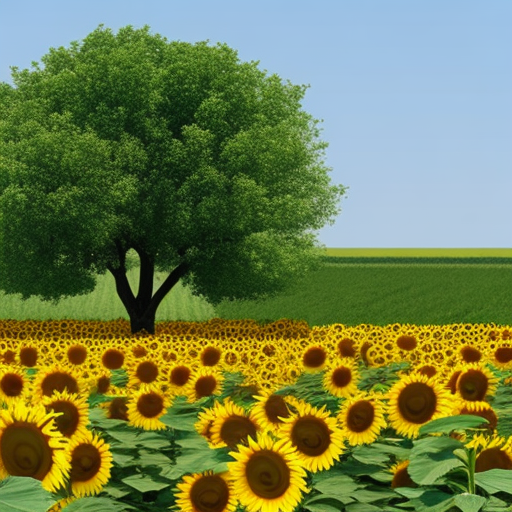

  0%|          | 0/25 [00:00<?, ?it/s]

np.float64(7.292994678204886e-27)

In [29]:
trwcomp = TreeRingWatermarkCOMPLEX(10,w_channel=3)
latent = trwcomp.generate()
img = generate_image(pipe,latent.squeeze(0),prompt)
display(img)
inverted = invert_image(inv_pipe,img)
trwcomp.verify(inverted)

the verification is done by performing a chi squared test and reporting a p value. The smaller the better.

In [30]:
#free RAM on GPU
del latent, inverted
torch.cuda.empty_cache()

# Gaussian Shading*
This task is optinal.

We now switch to a different idea. We want to put a message (like a user id) into the watermark. We further want each latent pixel to depend on one of the message bits. Furthermore, we need some redundancy because the inversion is only approximate.
For this, we introduce a repetition code, which means that each bit gets repeated a bunch of times to account for some bit flips. A repetition code would look like a bar code in the image, which is clearly not random and would degenerate the image quality. Therefore, we randomise it by applying a one time pad encryption. This essentially means: We generate a random sequence of bits which is as long as the encoded latent from some (secret) seed we know and XOR it to the code word. Finally, we use our bits only for the signs of the values in a sence that e.g. if we base our gaussian value on a bit b=1, we draw a positive gaussian value and if b=0 a negative one.
The verification needs to undo all these steps.

On top, we want to give an answer if the message we recover actually makes sense. This is why we store all message we created in a list. In the real world, this is fine because we e.g. know all the user ids of our system.

The class gives you predefined methods to follow along. Have a look at generate and verify to see how these methods are actually stacked.

Here is the algorithm as pseudocode:

generate(message):
1. insert message in messages list
1. codeword = repetition_encode(message)
1. ciphertext = randomise(codeword)
1. latent = sample(ciphertext)

verify(latent):
1. ciphertext = inverse_sampler(latent)
1. codeword = derandomise(ciphertext) //decrypt
1. message_prime = repetition_decode(codeword)
1. check if message_prime is part of the original messages
1. (compute accuracy with which message was found)

In [ ]:
class GaussianShadingWatermark:
    def __init__(self,message_length = 256):
        pass
        self.lantent_height = 64
        self.latent_channel = 4
        self.latent_length = self.lantent_height*self.lantent_height*self.latent_channel
        self.repetition_number = self.latent_length//message_length
        self.message_length = message_length

        self.messages = list()

        #self.key = draw a random key as 128 bit integer

    def repetition_encode(self,message):
        #encode the message as a repetition code. Repeat every bit that much that you end up with a bitstring of latent_length
        #return codeword
        pass

    def repetition_decode(self,codeword):
        # get the original message out from the code word. Do this by doing a majority vote for every repeated original bit
        #return message
        pass

    def sample_latent(self,codeword):
        #for each bit of the codeword, you sample a gaussian value and pick the sign according to your code bit.
        # Is this actually gaussian distributed?
        #return latent
        pass

    def inverse_sampler(self,latent):
        #get from the latent to bits
        #return ciphertext
        pass

    def randomise(self,codeword): #= encrypt
        #generate a random sequence of bits with the key as seed
        # XOR to the codeword
        #return the result (ciphertext)
        pass

    def derandomise(self,ciphertext): #=decrypt
        #generate the same random bit sequence again
        # XOR to the ciphertext
        #return the recovered code word
        pass

    def generate(self,message):
        self.messages.append(message)
        #repition_encode message
        #randomise
        #sample latent
        #return latent
        pass

    def verify(self,latent):
        #recover ciphertext
        #derandomise
        #repetition decode
        #check if message in messages
        #return the message and true/false
        pass


# Solutions

Treering over the reals remains as an exercise. For solutions to Gaussian Shading, we refer to our implementation on github, which itself references the original code of the respective papers: https://github.com/and-mill/semantic-forgery

For a detailed explanation of both watermarking schemes, we refer to
https://arxiv.org/abs/2412.03283, Appendix A.

For an even more detailed explanation of Gaussian Shading and its pitfalls, we refer to https://arxiv.org/abs/2503.11404.